# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [4]:
azdias.info()#Demographics data for the general population of Germany

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [5]:
customers.info()#Demographics data for customers of a mail-order company

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [6]:
print (azdias.shape)
print (customers.shape)

(891221, 366)
(191652, 369)


>### Additional columns for customers dataframe

In [7]:
list(set(customers.columns) - set(azdias.columns))

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

In [8]:
customers[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']].tail()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
191647,COSMETIC_AND_FOOD,MULTI_BUYER,0
191648,COSMETIC,SINGLE_BUYER,0
191649,COSMETIC_AND_FOOD,MULTI_BUYER,0
191650,FOOD,SINGLE_BUYER,0
191651,COSMETIC_AND_FOOD,MULTI_BUYER,0


>### Converting data to csv file and uploading to S3 aws

In [9]:
#customers.to_csv('customers.csv')
#azdias.to_csv('azdias.csv')

# Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

## 1- Cleaning data and preprocessing

>### I. Identifying and dropping non values columns

In [10]:
# Identifying non values columns
#azdias_subset = azdias.select_dtypes(exclude=[np.float, np.int])
customers_subset = customers.select_dtypes(exclude=[np.float, np.int])

In [11]:
customers_subset.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER
4,7B,7,41,D19_SCHUHE,1992-02-12 00:00:00,W,FOOD,MULTI_BUYER


In [12]:
# Dropping non values columns
#clean_azdias = azdias.drop(['LNR','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ','EINGEFUEGT_AM'], axis=1)
clean_customers = customers.drop(['LNR','CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ','EINGEFUEGT_AM', 'PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], axis=1)

In [13]:
clean_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,1,4
2,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


>### II. Convert remaining non values data to numeric values otherwise replace with NaN

In [14]:
clean_customers = clean_customers.apply(pd.to_numeric, errors='coerce')
#clean_azdias = clean_azdias.apply(pd.to_numeric, errors='coerce')

>### III. Replacing unknown (-1) and none (0) values with NaN

In [15]:
clean_customers = clean_customers.replace(0, np.nan)
clean_customers = clean_customers.replace(-1, np.nan)

In [16]:
clean_customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2.0,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,NaN,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
1,NaN,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.0,6.0,3.0,NaN,9.0,NaN,3,1,4
2,NaN,1.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,1.0,1.0,8.0,NaN,NaN,NaN,NaN,8.0,NaN,NaN,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,NaN,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3


>### IV. Analyzing NaN values in dataset

,Total,Percent
D19_TELKO_ONLINE_QUOTE_12,191454,0.998967
ALTER_KIND4,191416,0.998769
D19_VERSI_ONLINE_QUOTE_12,191394,0.998654
ALTER_KIND3,190377,0.993347
SOHO_KZ,190221,0.992533


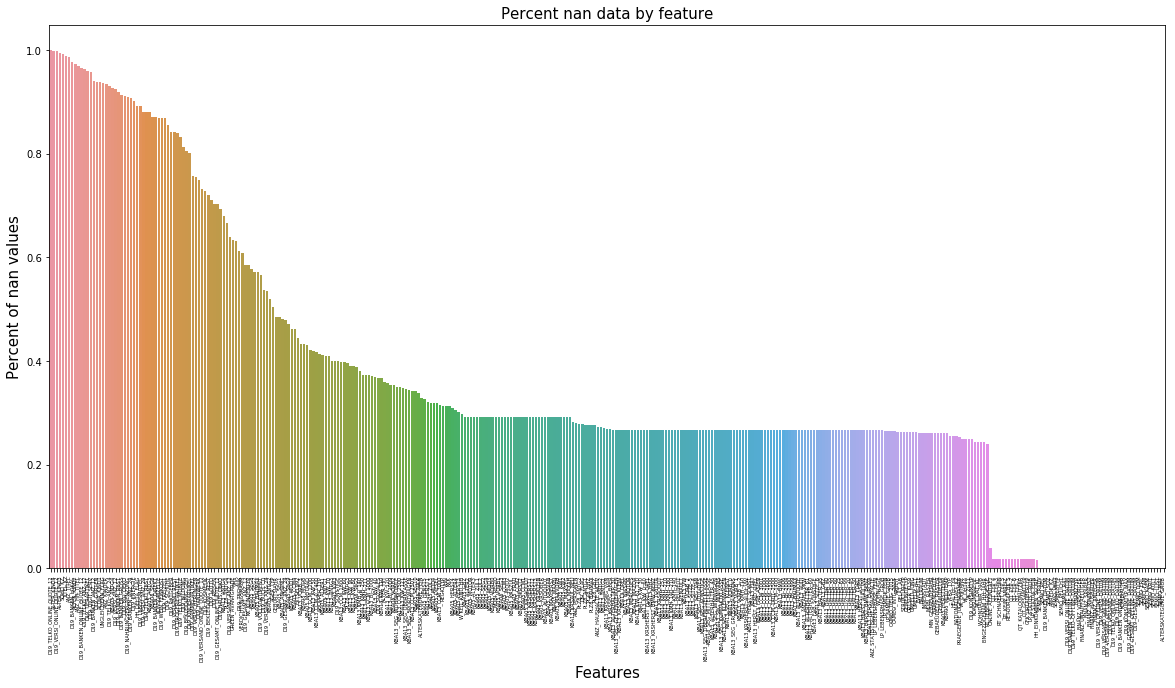

In [17]:
total = clean_customers.isna().sum().sort_values(ascending=False)
percent = (clean_customers.isna().sum()/clean_customers.isna().count()).sort_values(ascending=False)
nan_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

f, ax = plt.subplots(figsize=(20, 10))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(5)

    plt.xticks(rotation='90')
sns.barplot(x=nan_data.index, y=nan_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of nan values', fontsize=15)
plt.title('Percent nan data by feature', fontsize=15)

nan_data.head()

In [26]:
# Counting NaN values of each columns
nan_counts = clean_customers.apply(lambda x:x.isna().sum()).sort_values(ascending=False)
#clean_azdias.apply(lambda x:x.isna().sum())
nan_counts

D19_TELKO_ONLINE_QUOTE_12     191454
ALTER_KIND4                   191416
D19_VERSI_ONLINE_QUOTE_12     191394
ALTER_KIND3                   190377
SOHO_KZ                       190221
TITEL_KZ                      189340
ANZ_TITEL                     188912
D19_BANKEN_LOKAL              187347
ALTER_KIND2                   186552
ANZ_HH_TITEL                  185564
D19_BANKEN_ONLINE_QUOTE_12    184858
D19_TELKO_ANZ_12              184467
D19_TIERARTIKEL               183788
D19_DIGIT_SERV                183539
D19_BANKEN_ANZ_12             180150
D19_GARTEN                    179969
ALTER_KIND1                   179886
UNGLEICHENN_FLAG              179359
ANZ_KINDER                    178880
D19_TELKO_ANZ_24              178411
KBA05_ANTG4                   177467
D19_VERSI_ANZ_12              177236
D19_BANKEN_REST               176243
D19_BANKEN_GROSS              175064
D19_BIO_OEKO                  174542
D19_NAHRUNGSERGAENZUNG        174094
D19_BANKEN_ANZ_24             173701
D

In [27]:
clean_customers.shape

(191652, 361)

>###  V. Dropping columns with more than 10% of NaN values

In [28]:
clean_customers_dropna = clean_customers.loc[:, pd.notnull(clean_customers).sum()>len(clean_customers)*.9]

In [29]:
clean_customers_dropna.columns, len(clean_customers_dropna.columns)

(Index(['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2',
        'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_DATUM',
        'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM',
        'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
        'D19_GESAMT_ONLINE_DATUM', 'D19_KONSUMTYP_MAX', 'D19_TELKO_DATUM',
        'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
        'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_VERSAND_ONLINE_DATUM', 'D19_VERSI_DATUM',
        'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'FINANZ_ANLEGER',
        'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER',
        'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'FINANZTYP',
        'GFK_URLAUBERTYP', 'HH_EINKOMMEN_SCORE', 'KOMBIALTER', 'LP_STATUS_FEIN',
        'LP_STATUS_GROB', 'ONLINE_AFFINITAET', 'RETOURTYP_BK_S',
        'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN', 'SEMIO_DOM', 'SEMIO_ERL',
        'SEMIO_FAM', 'SEMIO_KAEM', 'SEMIO_KRIT', 'SE

In [30]:
clean_customers_dropna.shape

(191652, 57)

>### VI. Dropping the rows only if all of the values in the row are missing

In [31]:
clean_customers_dropna = clean_customers_dropna.dropna(how='all')
# clean_azdias = clean_azdias.dropna(axis = 0)

In [32]:
clean_customers_dropna.shape

(191652, 57)

>### VII. Replacing NaNs with -1 value

In [33]:
clean_customers_fillna = clean_customers_dropna.fillna(-1)

>### VIII. Checking data type and cleaned values

In [35]:
# Counting NaN values for each column
clean_customers_fillna.apply(lambda x:x.isna().sum())

CJT_GESAMTTYP                0
CJT_KATALOGNUTZER            0
CJT_TYP_1                    0
CJT_TYP_2                    0
CJT_TYP_3                    0
CJT_TYP_4                    0
CJT_TYP_5                    0
CJT_TYP_6                    0
D19_BANKEN_DATUM             0
D19_BANKEN_OFFLINE_DATUM     0
D19_BANKEN_ONLINE_DATUM      0
D19_GESAMT_DATUM             0
D19_GESAMT_OFFLINE_DATUM     0
D19_GESAMT_ONLINE_DATUM      0
D19_KONSUMTYP_MAX            0
D19_TELKO_DATUM              0
D19_TELKO_OFFLINE_DATUM      0
D19_TELKO_ONLINE_DATUM       0
D19_VERSAND_DATUM            0
D19_VERSAND_OFFLINE_DATUM    0
D19_VERSAND_ONLINE_DATUM     0
D19_VERSI_DATUM              0
D19_VERSI_OFFLINE_DATUM      0
D19_VERSI_ONLINE_DATUM       0
FINANZ_ANLEGER               0
FINANZ_HAUSBAUER             0
FINANZ_MINIMALIST            0
FINANZ_SPARER                0
FINANZ_UNAUFFAELLIGER        0
FINANZ_VORSORGER             0
FINANZTYP                    0
GFK_URLAUBERTYP              0
HH_EINKO

In [36]:
# Data types
set(clean_customers_fillna.dtypes)

{dtype('int64'), dtype('float64')}

>### IX. Normalizing the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

customers_scaled = pd.DataFrame(scaler.fit_transform(clean_customers_fillna.astype(float)))
customers_scaled.index = clean_customers_fillna.index
customers_scaled.columns = clean_customers_fillna.columns

### Save cleaned the data as pickle file

In [95]:
customers_scaled.to_pickle("cleaned_customers.pkl")

## 2- Visuzalization of cleaned data

>### I. Histogram

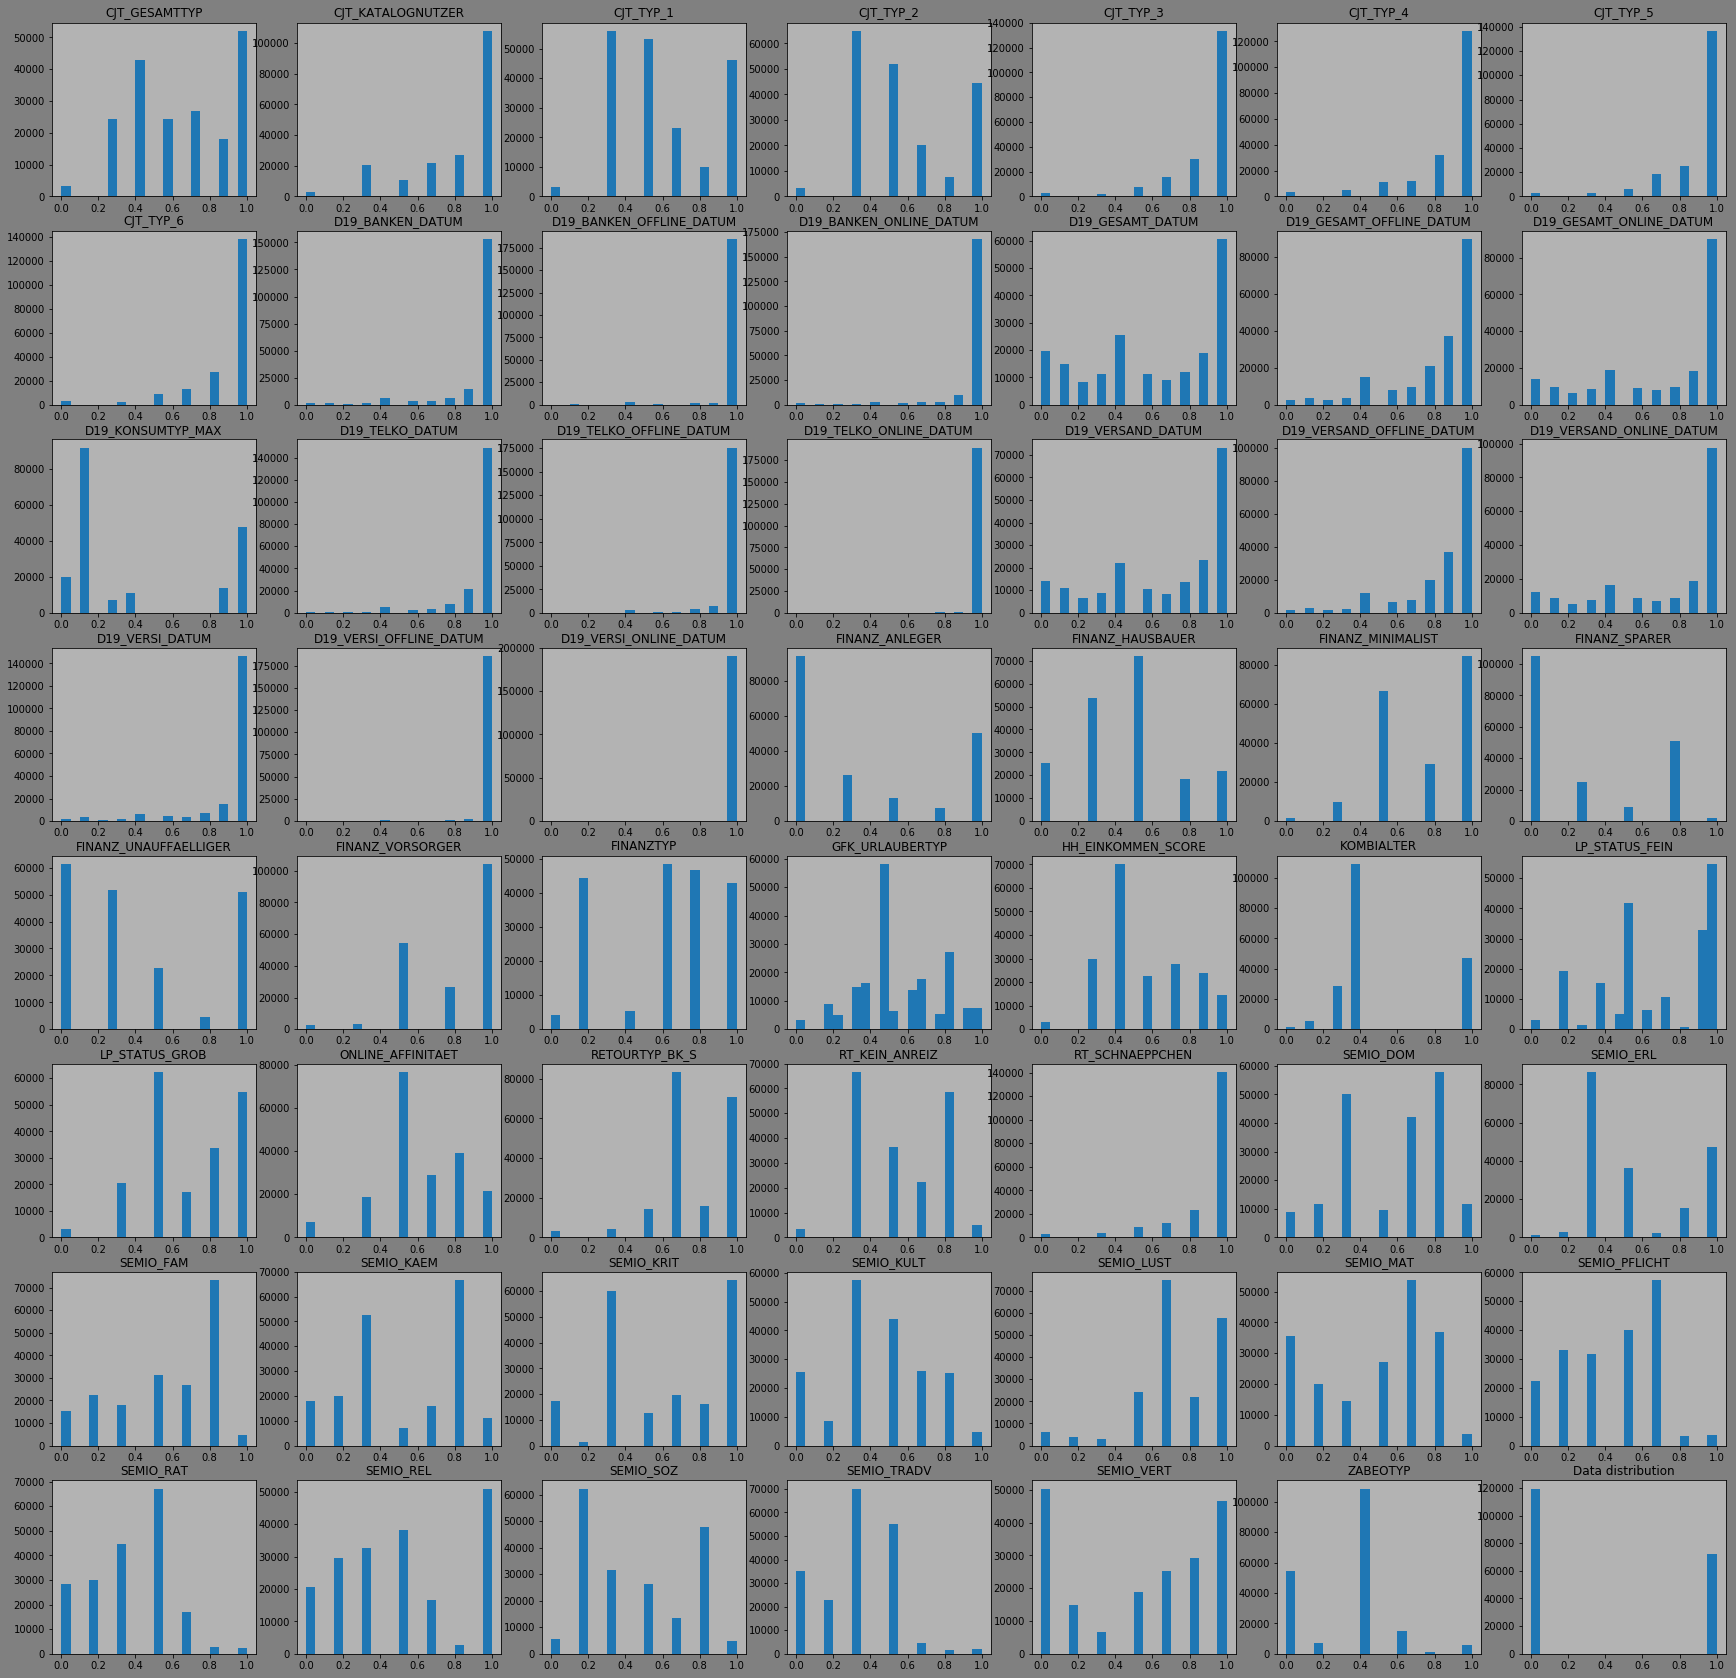

In [109]:
fig, axs = plt.subplots(8,7, figsize = (30,30))
axs = axs.flatten()

for i,name in list(zip(range(len(axs)),customers_scaled.columns[:len(axs)])):
    axs[i].set_title(name)
    axs[i].hist(customers_scaled[name], bins=20)
plt.title ('Data distribution')
plt.show()

>### II. Correlation matrix heatmap

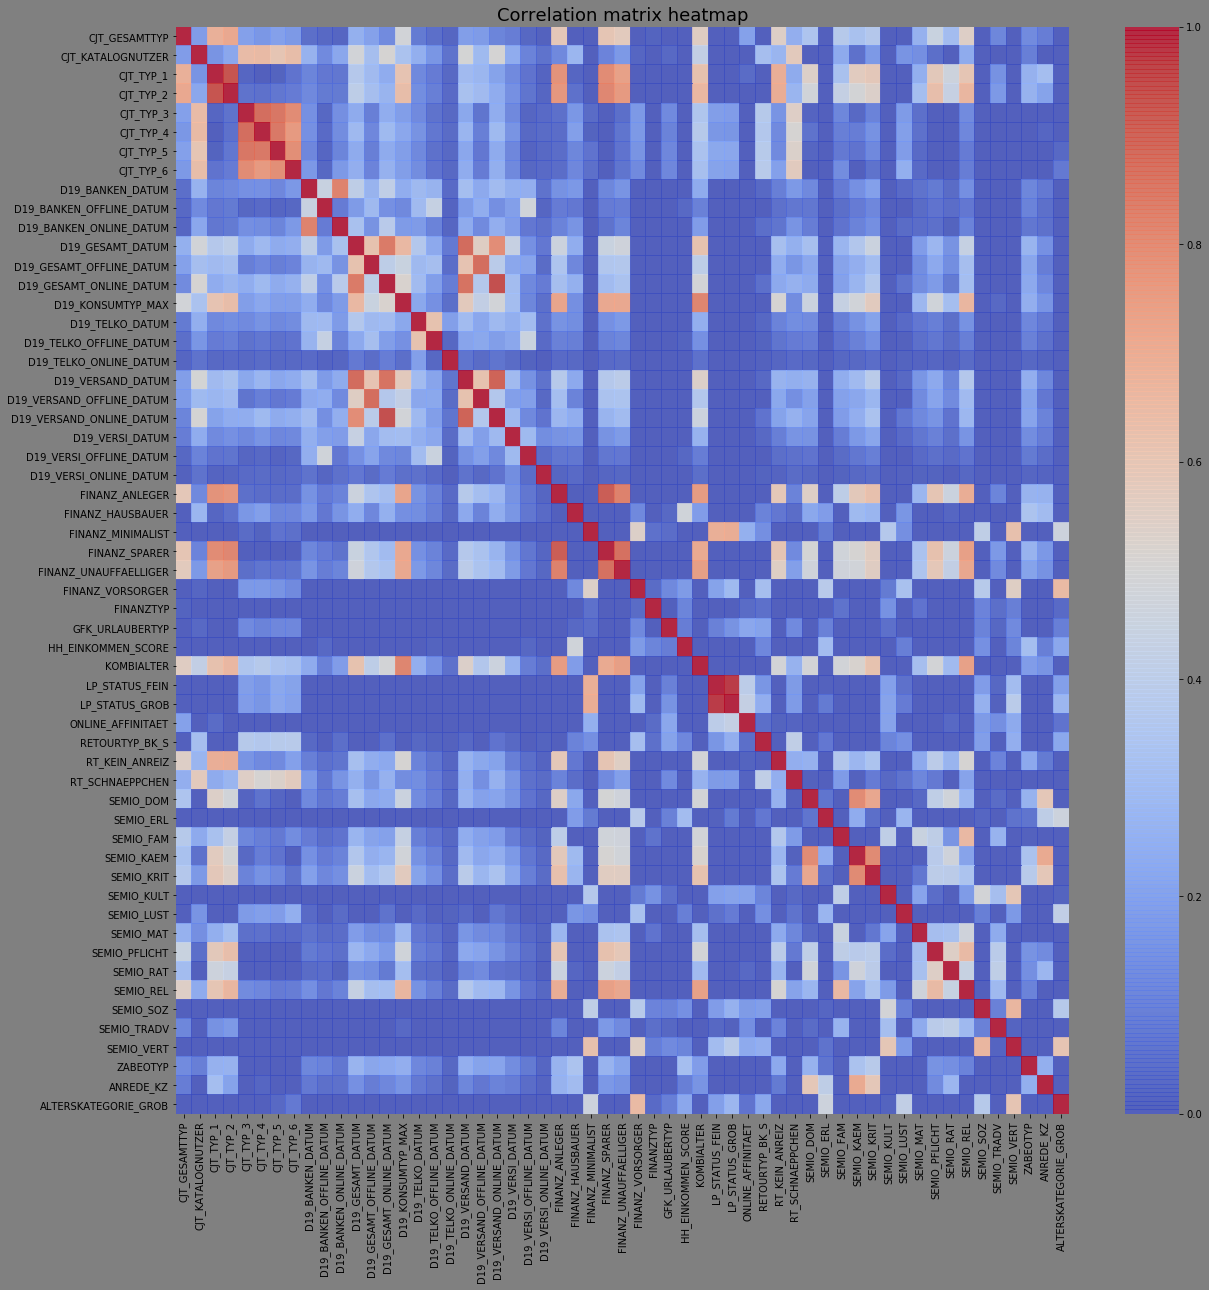

In [103]:
plt.figure(figsize=(20,20))
plt.title('Correlation matrix heatmap', fontsize=18)
sns.heatmap(customers_scaled.corr(), vmin=0, vmax=1, cmap="coolwarm", alpha=0.8);

In [104]:
customers_scaled.describe()

,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_DATUM,D19_BANKEN_OFFLINE_DATUM,...,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,...,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,0.657072,0.820992,0.600665,0.581500,0.903981,0.887422,0.904569,0.907663,0.929733,0.985164,...,0.480527,0.421376,0.360980,0.518798,0.457023,0.319860,0.530880,0.315361,0.376432,0.257613
std,0.270904,0.251845,0.267220,0.268327,0.186631,0.205276,0.189334,0.188392,0.182585,0.085806,...,0.306688,0.248986,0.219370,0.345160,0.286340,0.203204,0.394568,0.233697,0.484492,0.135782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.428571,0.666667,0.333333,0.333333,0.833333,0.833333,0.833333,0.833333,1.000000,1.000000,...,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.250000
50%,0.714286,1.000000,0.500000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.500000,0.500000,0.333333,0.500000,0.333333,0.333333,0.666667,0.400000,0.000000,0.250000
75%,1.000000,1.000000,0.833333,0.833333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.666667,0.666667,0.500000,1.000000,0.833333,0.500000,0.833333,0.400000,1.000000,0.375000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [105]:
customers_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 0 to 191651
Data columns (total 57 columns):
CJT_GESAMTTYP                191652 non-null float64
CJT_KATALOGNUTZER            191652 non-null float64
CJT_TYP_1                    191652 non-null float64
CJT_TYP_2                    191652 non-null float64
CJT_TYP_3                    191652 non-null float64
CJT_TYP_4                    191652 non-null float64
CJT_TYP_5                    191652 non-null float64
CJT_TYP_6                    191652 non-null float64
D19_BANKEN_DATUM             191652 non-null float64
D19_BANKEN_OFFLINE_DATUM     191652 non-null float64
D19_BANKEN_ONLINE_DATUM      191652 non-null float64
D19_GESAMT_DATUM             191652 non-null float64
D19_GESAMT_OFFLINE_DATUM     191652 non-null float64
D19_GESAMT_ONLINE_DATUM      191652 non-null float64
D19_KONSUMTYP_MAX            191652 non-null float64
D19_TELKO_DATUM              191652 non-null float64
D19_TELKO_OFFLINE_DATUM      191652 non-n

# Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [73]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [83]:
mailout_train

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
5,1789,3,1.0,12.0,NaN,NaN,NaN,NaN,12.0,17.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3
6,1795,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,2.0,...,6.0,6.0,3.0,6.0,9.0,2.0,3,0,2,4
7,1493,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,1.0,1.0,6.0,9.0,7.0,3,0,2,4
8,1801,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,3
9,1834,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,1


# Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [74]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
mailout_test

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
5,1782,2,1.0,7.0,NaN,NaN,NaN,NaN,7.0,66.0,...,4.0,9.0,10.0,7.0,6.0,9.0,3.0,6,1,4
6,1485,2,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,1.0,2.0,1.0,6.0,9.0,3.0,3,2,4
7,1519,-1,1.0,20.0,NaN,NaN,NaN,NaN,15.0,1.0,...,2.0,4.0,5.0,4.0,2.0,9.0,3.0,4,2,3
8,1835,1,1.0,19.0,NaN,NaN,NaN,NaN,13.0,2.0,...,1.0,1.0,1.0,1.0,4.0,9.0,7.0,1,2,3
9,1522,1,1.0,0.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,5.0,8.0,9.0,3.0,4.0,2.0,4,1,3


In [82]:
set(mailout_test.columns == azdias.columns)

{True}